In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

[SQL style guide](https://www.sqlstyle.guide/)

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
def run_command(q):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(q)

In [4]:
def show_tables():
    query = """
        SELECT
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table","view");
          """
    return run_query(query)

In [12]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [5]:
query = """
    WITH genre_sold 
    AS
        (SELECT
            g.name genre_name,
            SUM(il.quantity) sold_tracks
        FROM genre g
        INNER JOIN track t ON t.genre_id = g.genre_id
        INNER JOIN invoice_line il ON t.track_id = il.track_id
        GROUP BY genre_name
        )
    SELECT genre_name,
           sold_tracks,
           CAST(sold_tracks AS float) / (select sum(sold_tracks) from genre_sold) sold_tracks_percent
    FROM genre_sold
    ORDER BY sold_tracks DESC;
          """

In [6]:
sold_tracks = run_query(query)
sold_tracks

,genre_name,sold_tracks,sold_tracks_percent
0,Rock,2635,0.553921
1,Metal,619,0.130124
2,Alternative & Punk,492,0.103427
3,Latin,167,0.035106
4,R&B/Soul,159,0.033424
5,Blues,124,0.026067
6,Jazz,121,0.025436
7,Alternative,117,0.024595
8,Easy Listening,74,0.015556
9,Pop,63,0.013244


In [7]:
sold_tracks.set_index('genre_name', drop=True, inplace = True)

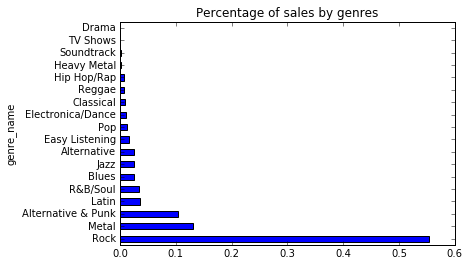

In [8]:
sold_tracks.sold_tracks_percent.plot.barh(title='Percentage of sales by genres')

CALCULATE:
Three artists whose albums we should purchase for the store, based on sales of tracks from their genres.

In [9]:
query = 'select * from employee limit 3;'
run_query(query)

,employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
0,1,Adams,Andrew,General Manager,NaN,1962-02-18 00:00:00,2016-08-14 00:00:00,11120 Jasper Ave NW,Edmonton,AB,Canada,T5K 2N1,+1 (780) 428-9482,+1 (780) 428-3457,andrew@chinookcorp.com
1,2,Edwards,Nancy,Sales Manager,1.0,1958-12-08 00:00:00,2016-05-01 00:00:00,825 8 Ave SW,Calgary,AB,Canada,T2P 2T3,+1 (403) 262-3443,+1 (403) 262-3322,nancy@chinookcorp.com
2,3,Peacock,Jane,Sales Support Agent,2.0,1973-08-29 00:00:00,2017-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com


In [10]:
query = 'select title, city, COUNT(*) "count of employee" from employee group by title order by 3;'
run_query(query)

,title,city,count of employee
0,General Manager,Edmonton,1
1,IT Manager,Calgary,1
2,Sales Manager,Calgary,1
3,IT Staff,Lethbridge,2
4,Sales Support Agent,Calgary,3


In [11]:
query = """
    WITH sup_ii
    AS
        (
        SELECT
            c.support_rep_id,
            SUM(i.total) total_sales
        FROM customer c
        LEFT JOIN invoice i ON c.customer_id = i.customer_id
        GROUP BY support_rep_id
        )
SELECT
    e.first_name || ' ' || e.last_name employee_name,
    sup_ii.total_sales
FROM employee e 
LEFT JOIN sup_ii ON e.employee_id = sup_ii.support_rep_id
WHERE e.title = 'Sales Support Agent';
          """
sales_by_sup_agent = run_query(query)
sales_by_sup_agent

,employee_name,total_sales
0,Jane Peacock,1731.51
1,Margaret Park,1584.00
2,Steve Johnson,1393.92


BY COUNTRIES:
* total number of customers
* total value of sales
* average value of sales per customer
* average order value

In [13]:
# query = "DROP VIEW countries_info;"
# run_command(query)

In [14]:
query = """
  CREATE VIEW countries_info AS  
    WITH c_var AS
        (SELECT c.country,
                COUNT(DISTINCT c.customer_id) count_customers,
                COUNT(i.customer_id) count_orders,
                SUM(i.total) total_sales
        FROM customer c
        LEFT JOIN invoice i ON c.customer_id = i.customer_id
        GROUP BY country)
        
    SELECT c_var.*,
           CASE
               WHEN c_var.count_customers = 1 THEN "Other"
               ELSE c_var.country
               END AS country_category
    FROM c_var;
        """
run_command(query)
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [15]:
query = """
    SELECT 
        country_category,
        SUM(count_customers) count_customers,
        SUM(count_orders) count_orders,
        SUM(total_sales) total_sales,
        CAST(SUM(total_sales) as float) / SUM(count_customers) avg_sum_per_customer,
        CAST(SUM(total_sales) as float) / SUM(count_orders) avg_order
    FROM countries_info
    GROUP BY country_category
    ORDER BY total_sales DESC;
        """
countries_info = run_query(query)
countries_info

,country_category,count_customers,count_orders,total_sales,avg_sum_per_customer,avg_order
0,Other,15,147,1094.94,72.996000,7.448571
1,USA,13,131,1040.49,80.037692,7.942672
2,Canada,8,76,535.59,66.948750,7.047237
3,Brazil,5,61,427.68,85.536000,7.011148
4,France,5,50,389.07,77.814000,7.781400
5,Germany,4,41,334.62,83.655000,8.161463
6,Czech Republic,2,30,273.24,136.620000,9.108000
7,United Kingdom,3,28,245.52,81.840000,8.768571
8,Portugal,2,29,185.13,92.565000,6.383793
9,India,2,21,183.15,91.575000,8.721429


In [16]:
countries_viz = countries_info[countries_info['country_category'] != 'Other'].set_index('country_category',drop=True)

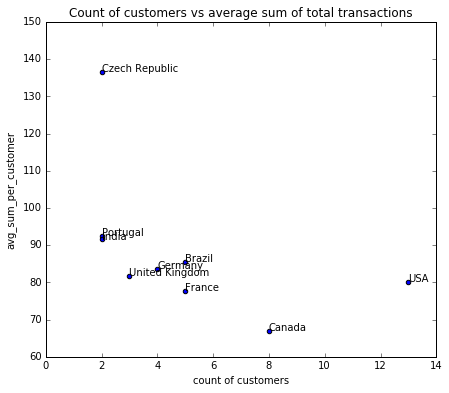

In [32]:
fig, ax = plt.subplots(figsize=(7,6))

ax.scatter(countries_viz.count_customers, countries_viz.avg_sum_per_customer)
ax.set_title('Count of customers vs average sum of total transactions')
ax.set_xlabel('count of customers')
ax.set_ylabel('avg_sum_per_customer')

for i, txt in enumerate(list(countries_viz.index)):
    ax.annotate(txt, (countries_viz.count_customers[i], countries_viz.avg_sum_per_customer[i]))

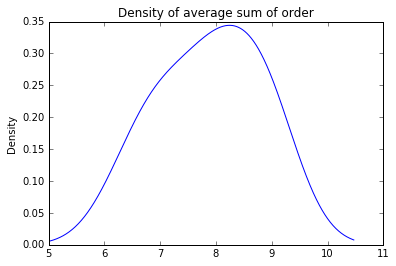

In [35]:
countries_viz.avg_order.plot(kind='kde', title='Density of average sum of order') 

Let's see all count of invoices

In [68]:
query = "select count(distinct invoice_id) count_invoices from invoice_line;"
run_query(query)

,count_invoices
0,614


In [108]:
query = """
CREATE VIEW albums_sales AS
    WITH
    track_album AS
        (SELECT  
                track_id,
                album_id
        FROM track
        )
                ,
        
    track_album_invoice AS
        (SELECT 
            t.track_id,
            t.album_id,
            il.invoice_id
         FROM track t
         INNER JOIN invoice_line il ON il.track_id = t.track_id
        )

     SELECT
         tai.invoice_id,
         tai.album_id,
         COUNT(DISTINCT tai.track_id) count_tracks_invice,
         COUNT(DISTINCT ta.track_id) count_tracks_albums
     FROM track_album_invoice tai
     INNER JOIN track_album ta ON tai.album_id = ta.album_id
     GROUP BY tai.invoice_id, tai.album_id
     ORDER BY tai.invoice_id;
        """
run_command(query)

If we do not delete ids of purchases, where there were albums with one track

In [113]:
query = """
    SELECT 
    CASE
        WHEN count_tracks_invice = count_tracks_albums THEN "full_album"
        ELSE "separately"
        END AS invoice_category,
    COUNT(DISTINCT invoice_id) count_invoices
FROM albums_sales 
GROUP BY invoice_category;
        """
run_query(query)

,invoice_category,count_invoices
0,full_album,201
1,separately,500


If we did

In [118]:
query = """
         SELECT 
    CASE
        WHEN count_tracks_invice = count_tracks_albums THEN "full_album"
        ELSE "separately"
        END AS invoice_category,
    COUNT(DISTINCT invoice_id) count_invoices
FROM albums_sales 
WHERE invoice_id NOT IN (SELECT DISTINCT invoice_id FROM albums_sales WHERE count_tracks_albums =1)
GROUP BY invoice_category;
        """
sales_album = run_query(query)
sales_album

,invoice_category,count_invoices
0,full_album,111
1,separately,413


In [119]:
sales_album['percents'] = sales_album['count_invoices'] / sum(sales_album['count_invoices']) * 100
sales_album

,invoice_category,count_invoices,percents
0,full_album,111,21.183206
1,separately,413,78.816794


To ask next questions we can see to the [schema](https://s3.amazonaws.com/dq-content/191/chinook-schema.svg)

* Which artist is used in the most playlists?
* How many tracks have been purchased vs not purchased?
* Is the range of tracks in the store reflective of their sales popularity?
* Do protected vs non-protected media types have an effect on popularity?